#  Time interpolation

In [1]:
import numpy as np

from mikeio import Dfs2

dfs2 = Dfs2("../tests/testdata/waves.dfs2")
dfs2

<mikeio.Dfs2>
dx: 50.00000
dy: 50.00000
Items:
  0:  Sign. Wave Height <Significant wave height> (meter)
  1:  Peak Wave Period <Wave period> (second)
  2:  Mean Wave Direction <Mean Wave Direction> (degree)
Time: 3 steps
Start time: 2004-01-01 00:00:00

In [2]:
ds = dfs2.read()
ds

<mikeio.Dataset>
Dimensions: (3, 31, 31)
Time: 2004-01-01 00:00:00 - 2004-01-03 00:00:00
Items:
  0:  Sign. Wave Height <Significant wave height> (meter)
  1:  Peak Wave Period <Wave period> (second)
  2:  Mean Wave Direction <Mean Wave Direction> (degree)

## Interpolate to specific timestep

In [3]:
ds_h = ds.interp_time(3600)
ds_h

<mikeio.Dataset>
Dimensions: (49, 31, 31)
Time: 2004-01-01 00:00:00 - 2004-01-03 00:00:00
Items:
  0:  Sign. Wave Height <Significant wave height> (meter)
  1:  Peak Wave Period <Wave period> (second)
  2:  Mean Wave Direction <Mean Wave Direction> (degree)

In [4]:
dfs2.write("waves_3h.dfs2",ds_h)

## Interpolate to time axis of another dataset

Read some non-equidistant "observations".

In [5]:
from mikeio import Dfs0

dfs0 = Dfs0("../tests/testdata/waves.dfs0")
ts = dfs0.read()
ts

<mikeio.Dataset>
Dimensions: (24,)
Time: 2004-01-01 01:00:00 - 2004-01-03 12:00:10
-- Non-equidistant calendar axis --
Items:
  0:  Sign. Wave Height <Undefined> (undefined)
  1:  Peak Wave Period <Undefined> (undefined)
  2:  Mean Wave Direction <Undefined> (undefined)

The observed timeseries is longer than the modelled data. Default is to fill values with NaN.

In [6]:
dsi = ds.interp_time(ts.time)

In [7]:
dsi["Sign. Wave Height"][:,1,0]

array([0.06543457, 0.06661261, 0.06779064, 0.06896868, 0.07014672,
       0.07132475, 0.07250279, 0.07368083, 0.09135137, 0.09252941,
       0.09108364, 0.08963786, 0.08819209, 0.08674632, 0.08530055,
       0.08385478, 0.082409  , 0.08096323, 0.07951746, 0.06361397,
       0.0621682 , 0.05927665, 0.05783088,        nan])

In [8]:
dsi["Sign. Wave Height"].shape

(24, 31, 31)

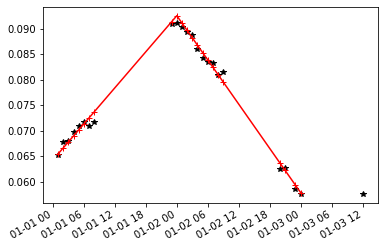

In [9]:
import matplotlib.pyplot as plt

plt.plot(ts.time,ts["Sign. Wave Height"],'k*',label="Observation")
plt.plot(dsi.time, dsi["Sign. Wave Height"][:,1,0],'r+-',label="Model")
plt.gcf().autofmt_xdate()

## Mean absolute error
Use `np.nanmean` to skip NaN.

In [10]:
mae = np.nanmean(np.abs(ts["Sign. Wave Height"] - dsi["Sign. Wave Height"][:,1,0]))
mae

0.0008009996575613816

# Clean up

In [11]:
import os
os.remove("waves_3h.dfs2")